In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost 
import time
import joblib
from utils import prepare_test_dataset, plot_signals, score

In [2]:
pd.set_option('display.max_columns', None) # show all columns of a data frame

In [3]:
parent_dir = os.path.dirname(os.getcwd())
train_file = os.path.join(parent_dir, 'CMAPSS_Data', 'train_FD001.txt')
test_file = os.path.join(parent_dir, 'CMAPSS_Data', 'test_FD001.txt')
rul_file = os.path.join(parent_dir, 'CMAPSS_Data','RUL_FD001.txt')
weight_path = os.path.join(parent_dir, 'weights')

In [4]:
raw_train_df = pd.read_csv(train_file, sep=r"\s+", header=None)
raw_test_df = pd.read_csv(test_file, sep=r"\s+", header=None)
print(raw_train_df.shape)
print(raw_test_df.shape)

(20631, 26)
(13096, 26)


In [5]:
columns = ['unit_number','time_in_cycles','op_set_1','op_set_2','op_set_3','sm_1','sm_2','sm_3','sm_4','sm_5','sm_6','sm_7',
           'sm_8','sm_9','sm_10','sm_11','sm_12','sm_13','sm_14','sm_15','sm_16','sm_17','sm_18','sm_19','sm_20','sm_21']
raw_train_df.columns = columns
raw_test_df.columns = columns

### Feature selection

In [6]:
raw_train_df.head()

,unit_number,time_in_cycles,op_set_1,op_set_2,op_set_3,sm_1,sm_2,sm_3,sm_4,sm_5,sm_6,sm_7,sm_8,sm_9,sm_10,sm_11,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
# get column wise statistics for the dataframe
raw_train_df.describe()

,unit_number,time_in_cycles,op_set_1,op_set_2,op_set_3,sm_1,sm_2,sm_3,sm_4,sm_5,sm_6,sm_7,sm_8,sm_9,sm_10,sm_11,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


Drop columns op_set_3, sm_1, sm_5, sm_10, sm_16, sm_18, sm_19 as they have constant values (std = 0)

In [8]:
raw_train_df.drop(columns=['op_set_3', 'sm_1', 'sm_5', 'sm_10', 'sm_16', 'sm_18', 'sm_19'], inplace=True)

In [9]:
def prepare_train_dataset(data):
    '''
    function to add an extra column "rul" to the dataframe that stores the remaining useful life for each observation.
    '''
    df = data.copy()
    rul = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    rul = pd.DataFrame(rul)
    rul.columns = ['unit_number', 'last_cycle']
    df = df.merge(rul, on=['unit_number'], how='left')
    df['rul'] = df['last_cycle'] - df['time_in_cycles']
    df.drop(columns=['last_cycle'], inplace=True)
    return df[df['time_in_cycles'] > 0]

In [10]:
train_df = prepare_train_dataset(raw_train_df)
print(train_df.shape)
train_df.head()

(20631, 20)


,unit_number,time_in_cycles,op_set_1,op_set_2,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21,rul
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


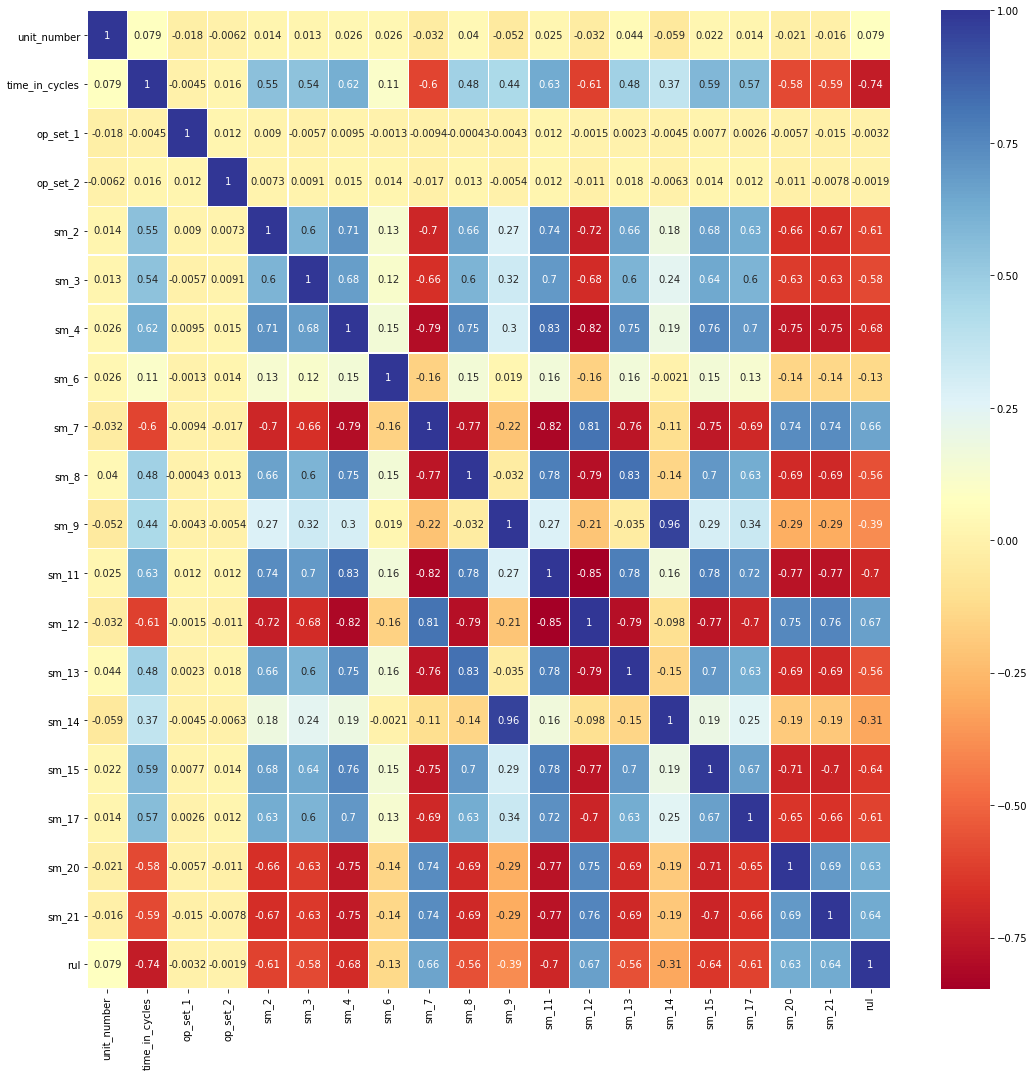

In [11]:
# plot correlation map to remove redundant variables
correlation_map = train_df.corr()
sns.heatmap(correlation_map, annot=True, cmap='RdYlBu', linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(18,18)
plt.show()

Remove sm_14 because it correlates strongly with sm_9.  
Remove op_set_1 and op_set_2 because they correlate weakly with rul

In [12]:
train_df.drop(columns=['unit_number','sm_14', 'op_set_1', 'op_set_2'], inplace=True)
print(train_df.shape)

(20631, 16)


In [13]:
X_train = train_df.iloc[:,:-1] 
y_train = train_df.iloc[:, -1]
print(X_train.shape)
print(y_train.shape)

(20631, 15)
(20631,)


In [14]:
X_train.head()

,time_in_cycles,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21
0,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190
1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236
2,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442
3,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739
4,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044


In [15]:
y_train.head()

0    191
1    190
2    189
3    188
4    187
Name: rul, dtype: int64

In [16]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
print(X_train.shape)
print(y_train.shape)

(20631, 15)
(20631,)


### Preparing the test set

In [17]:
raw_test_df.head()

,unit_number,time_in_cycles,op_set_1,op_set_2,op_set_3,sm_1,sm_2,sm_3,sm_4,sm_5,sm_6,sm_7,sm_8,sm_9,sm_10,sm_11,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [18]:
test_df = prepare_test_dataset(raw_test_df)
print(test_df.shape)
test_df.head()

(100, 15)


,time_in_cycles,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21
0,31,642.58,1581.22,1398.91,21.61,554.42,2388.08,9056.40,47.23,521.79,2388.06,8.4024,393,38.81,23.3552
1,49,642.55,1586.59,1410.83,21.61,553.52,2388.10,9044.77,47.67,521.74,2388.09,8.4505,391,38.81,23.2618
2,126,642.88,1589.75,1418.89,21.61,552.59,2388.16,9049.26,47.88,520.83,2388.14,8.4119,395,38.93,23.2740
3,106,642.78,1594.53,1406.88,21.61,552.64,2388.13,9051.30,47.65,521.88,2388.11,8.4634,395,38.58,23.2581
4,98,642.27,1589.94,1419.36,21.61,553.29,2388.10,9053.99,47.46,521.00,2388.15,8.4362,394,38.75,23.4117


In [19]:
X_test = test_df.to_numpy()
y_test = np.loadtxt(rul_file)
print(X_test.shape)
print(y_test.shape)

(100, 15)
(100,)


### Using Random Forest Regression

In [20]:
random_forest = RandomForestRegressor(n_estimators=70, max_features=7, max_depth=5, n_jobs=-1, random_state=1, criterion='mae')
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=5, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=70, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [21]:
y_rf_pred = random_forest.predict(X_test)

In [23]:
score(y_test, y_rf_pred)

Mean absolute error (in cycles) : 17.96
Root mean square error (in cycles) : 23.2
Coefficent of determination : 0.69


In [24]:
joblib.dump(random_forest, os.path.join(weight_path, 'random_forest.sav'))

['D:\\Projects\\machine_failure\\weights\\random_forest.sav']

### Using xgboost regression

In [25]:
xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.018, gamma=0, subsample=0.8, random_state=1, colsample_bytree=0.5, 
                           max_depth=3,verbosity=1)
xgb.fit(X_train, y_train)

[13:13:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.018, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=110,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [26]:
y_xgb_pred = xgb.predict(X_test)

In [27]:
score(y_test, y_xgb_pred)

Mean absolute error (in cycles) : 14.57
Root mean square error (in cycles) : 19.01
Coefficent of determination : 0.79


In [28]:
joblib.dump(xgb, os.path.join(weight_path, 'xgb.sav'))

['D:\\Projects\\machine_failure\\weights\\xgb.sav']

### Plotting sensor signals

In [29]:
features = train_df.columns[:-1]

print(features)
print(len(features))

Index(['time_in_cycles', 'sm_2', 'sm_3', 'sm_4', 'sm_6', 'sm_7', 'sm_8',
       'sm_9', 'sm_11', 'sm_12', 'sm_13', 'sm_15', 'sm_17', 'sm_20', 'sm_21'],
      dtype='object')
15


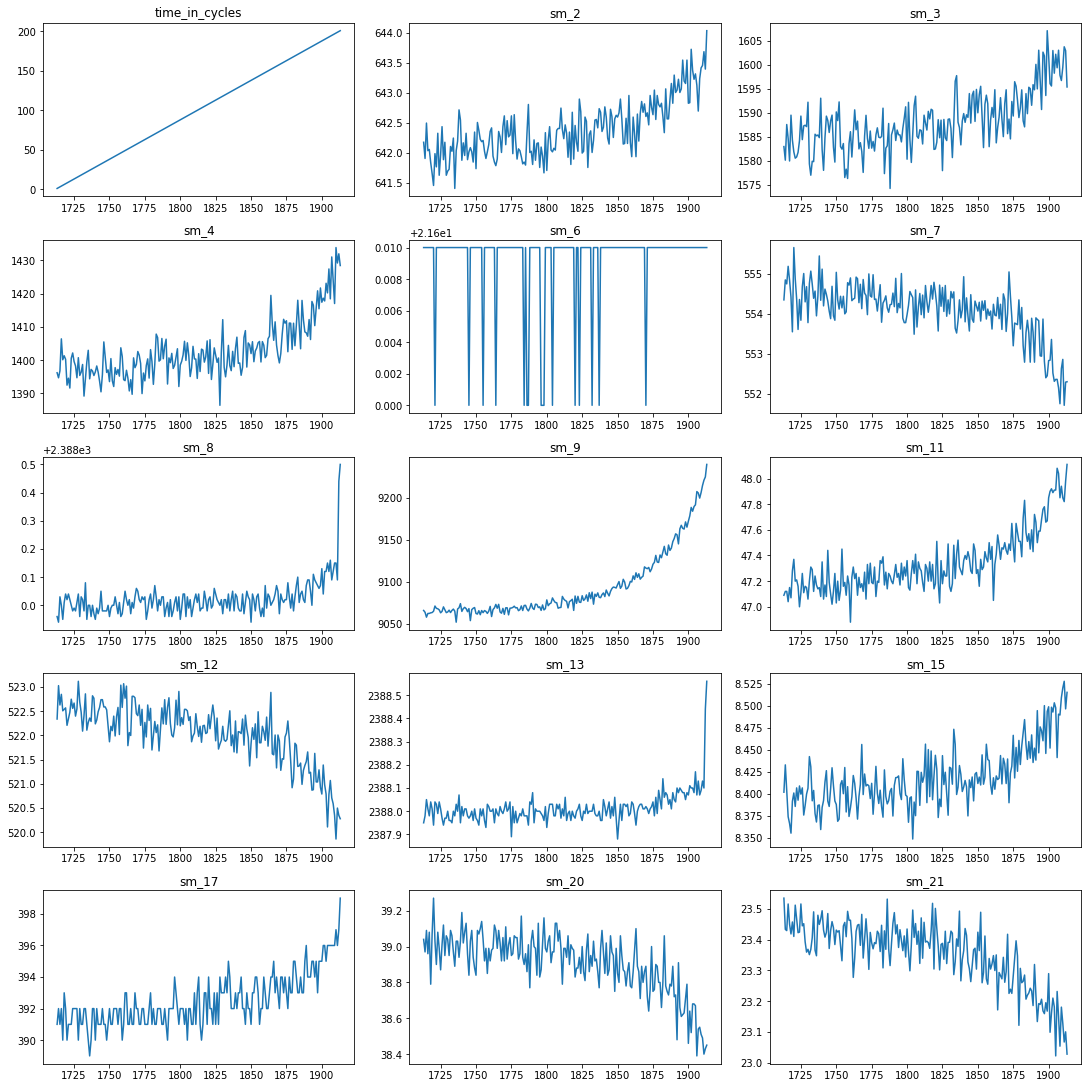

In [30]:
plot_signals(raw_train_df, features, 9)

### Linear Regression

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [32]:
X_train_norm = scaler.transform(X_train)

In [33]:
model = LinearRegression()
model.fit(X_train_norm, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
X_test_norm = scaler.transform(X_test)

In [35]:
y_lin_pred = model.predict(X_test_norm)

In [36]:
score(y_test, y_lin_pred)

Mean absolute error (in cycles) : 25.97
Root mean square error (in cycles) : 31.25
Coefficent of determination : 0.43
